In [2]:
import yfinance as yf

In [3]:
import pandas as pd

In [4]:
from pypfopt.efficient_frontier import EfficientFrontier
from  pypfopt import expected_returns, risk_models

In [19]:
from pypfopt import plotting

In [23]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
sp500 = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']

In [156]:
sp500.tolist()[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [166]:
etfs = pd.read_csv('quotes-3.csv')['Symbol']

In [172]:
personal = ['FXAIX', "SMH", ]

In [174]:
dfr = yf.download(
    sp500.tolist()+etfs.tolist()+personal, 
    period='4y')['Adj Close']


[*********************100%%**********************]  541 of 541 completed

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception("%ticker%: Period '4y' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")


In [175]:
dfr.shape

(1007, 541)

In [176]:
df=dfr.dropna(axis='rows', thresh=50).dropna(axis='columns', how='any')
df.shape

(1007, 534)

In [177]:
df.sample(3)

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-19,103.315277,12.56,113.625961,73.723137,102.094078,29.889999,216.232346,495.200012,115.092506,46.339146,...,25.087158,68.963882,64.469704,28.329779,42.695309,86.779175,91.240906,134.326920,291.570007,155.977127
2022-09-20,126.806755,13.97,155.570969,133.615967,99.352409,46.430000,263.872375,291.059998,145.643265,83.636597,...,27.896635,67.112839,69.813927,87.857742,29.973579,93.101440,112.044739,110.245041,285.649994,150.893921
2022-07-05,119.305618,13.88,140.166214,143.732117,105.670677,44.439999,267.733856,376.489990,138.452240,69.458252,...,31.825546,57.204288,65.971413,79.830307,35.085808,77.101440,113.510315,105.431618,302.329987,171.603912


In [178]:
' \N{GREEK small LETTER mu},\N{GREEK CAPITAL LETTER SIGMA} '


' μ,Σ '

# basic model

In [260]:
sp500cl = set(sp500) & set(df.columns)

In [406]:
risk_models.cov_to_corr(risk_models.sample_cov(df))[personal].sort_values('SMH')

Ticker,FXAIX,SMH
Ticker,,
CPB,0.130587,-0.038427
K,0.182692,-0.030393
SJM,0.196207,-0.014200
HRL,0.188688,0.008741
GIS,0.209876,0.009578
...,...,...
QQQ,0.920287,0.880046
LRCX,0.707546,0.887255
AMAT,0.711955,0.890436


In [407]:
len(etfs)

36

In [321]:
etfs.tolist()[32:]

['VCSH', 'VCIT', 'VTIP', 'QQQ']

In [303]:
{1,2,3} - {2}

{1, 3}

In [427]:
syms =  (set(etfs) - {'VCSH', 'VCIT', 'VTIP', 'QQQ'}) | sp500cl #| {'FXAIX'}
syms = sp500cl | set(personal)
len(syms)

498

In [428]:
mu = expected_returns.mean_historical_return(df[list(syms)])
S = risk_models.sample_cov(df[list(syms)])
mu.mean(), mu.max()

(0.21325990665716407, 1.6420202352976827)

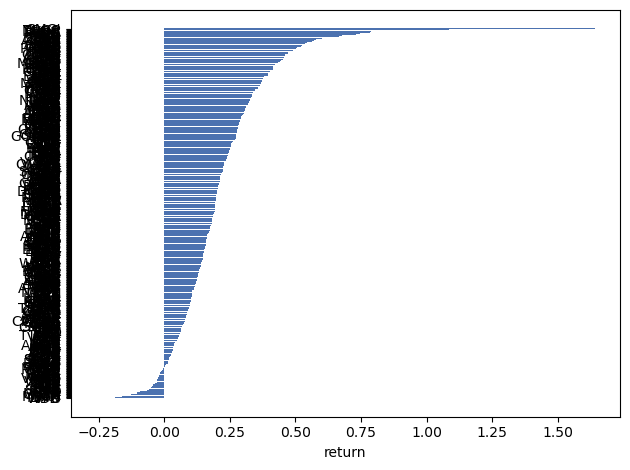

In [382]:
plotting.plot_weights(mu)
plotting.plt.xlabel('return');

In [315]:
len(set(df.columns))

534

In [274]:
import cvxpy

In [317]:
S = risk_models.fix_nonpositive_semidefinite(S, fix_method='diag')

In [318]:
Σ.loc[:] = cvxpy.psd_wrap(Σ, ).value

In [319]:
(Σ.values == cvxpy.psd_wrap(Σ, ).value).all()

True

In [429]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0.045)
# weights = ef.efficient_return(target_return=0.3)


weights = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 85.6%
Annual volatility: 24.6%
Sharpe Ratio: 3.30


In [430]:
ef.set_weights(weights)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 82.7%
Annual volatility: 23.8%
Sharpe Ratio: 3.29


In [431]:
weights={k:v for k,v in weights.items() if v>0}

In [432]:
wnames = {k+': '+name(k):v for k,v in weights.items()}

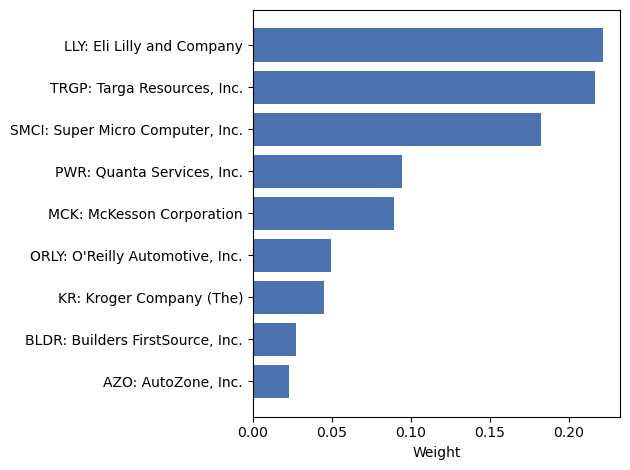

In [433]:
plotting.plot_weights(wnames,);

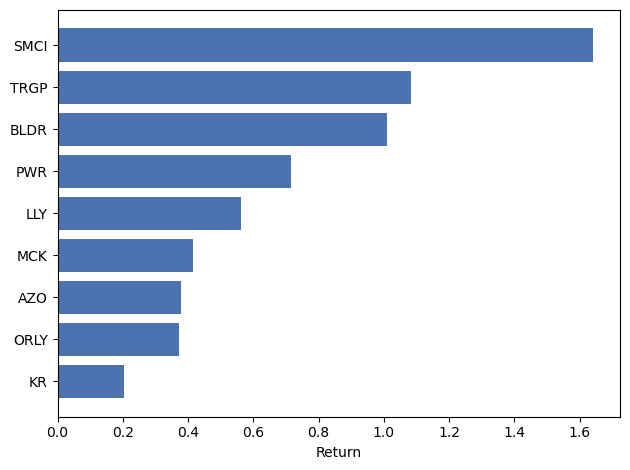

In [434]:
plotting.plot_weights(mu[weights.keys()], )
plotting.plt.xlabel('Return');

In [148]:
μ = expected_returns.ema_historical_return(df)
# Σ = risk_models.semicovariance(df)
Σ = risk_models.CovarianceShrinkage(df,).S


In [149]:
μ.mean()

0.23340079973405198

In [150]:
ef = EfficientFrontier(μ,Σ)
weights = ef.efficient_return(.3)
# weights = ef.efficient_risk(.12)
weights = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True);

Expected annual return: 30.0%
Annual volatility: 0.9%
Sharpe Ratio: 30.92


In [119]:
def name(sym):
    return yf.Ticker(sym).get_info()['shortName']
name('jnj')

'Johnson & Johnson'

In [408]:
from pypfopt.cla import CLA

CPU times: user 37.6 s, sys: 414 ms, total: 38 s
Wall time: 37.9 s


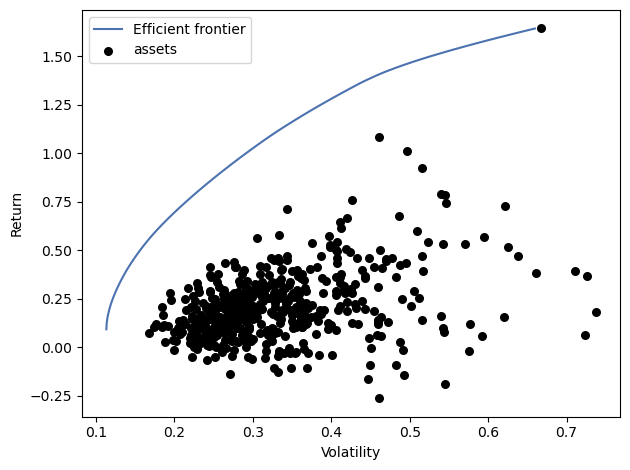

In [435]:
%%time 

plotting.plot_efficient_frontier(
    EfficientFrontier(mu, S), 
    show_tickers=False
);

# different losses

In [436]:
ef = EfficientFrontier(mu, S)

weights = ef.efficient_return(target_return=0.3)


weights = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 30.0%
Annual volatility: 12.7%
Sharpe Ratio: 2.02


In [437]:
ef.set_weights(weights)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 26.2%
Annual volatility: 11.0%
Sharpe Ratio: 1.97


In [438]:
weights={k:v for k,v in weights.items() if v>0}

In [439]:
wnames = {k+': '+name(k):v for k,v in weights.items()}

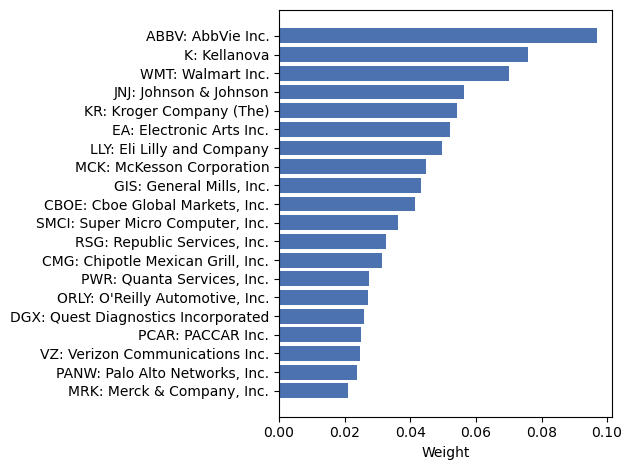

In [440]:
plotting.plot_weights(wnames,);

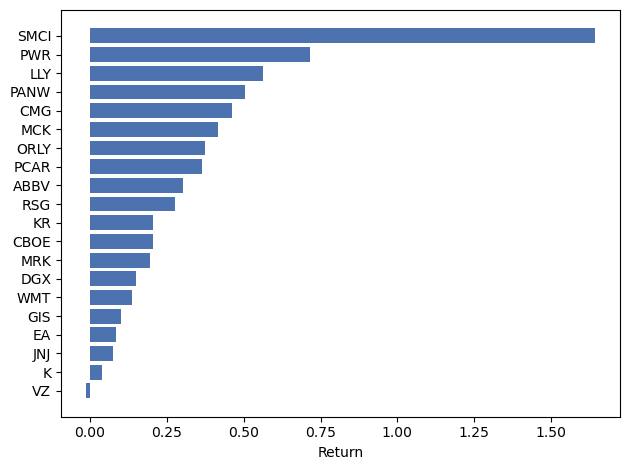

In [441]:
plotting.plot_weights(mu[weights.keys()], )
plotting.plt.xlabel('Return');

# target return with weight on recent

In [497]:
syms=sp500cl #| set(etfs.iloc[:18])

In [498]:
mu = expected_returns.ema_historical_return(df[list(syms)])
# Σ = risk_models.semicovariance(df)
S = risk_models.risk_matrix(df[list(syms)], method='exp_cov')


mu.quantile(.75)

0.36942632059346264

In [488]:
S = risk_models.fix_nonpositive_semidefinite(S, fix_method='spectral')  # diag

In [452]:
S.loc[:] = cvxpy.psd_wrap(S, ).value

In [489]:
(S.values == cvxpy.psd_wrap(S, ).value).all()

True

In [499]:
ef = EfficientFrontier(mu, S)

weights = ef.efficient_return(target_return=0.37)


weights_c = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 37.0%
Annual volatility: 6.8%
Sharpe Ratio: 4.76


In [500]:
ef.set_weights(weights_c)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 24.1%
Annual volatility: 5.7%
Sharpe Ratio: 3.46


In [501]:
weights_c={k:v for k,v in weights_c.items() if v>0}

In [502]:
wnames = {k+': '+name(k):v for k,v in weights_c.items()}

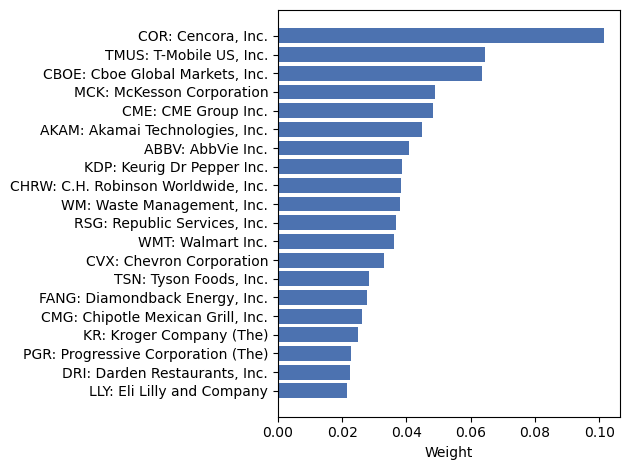

In [503]:
plotting.plot_weights(wnames,);

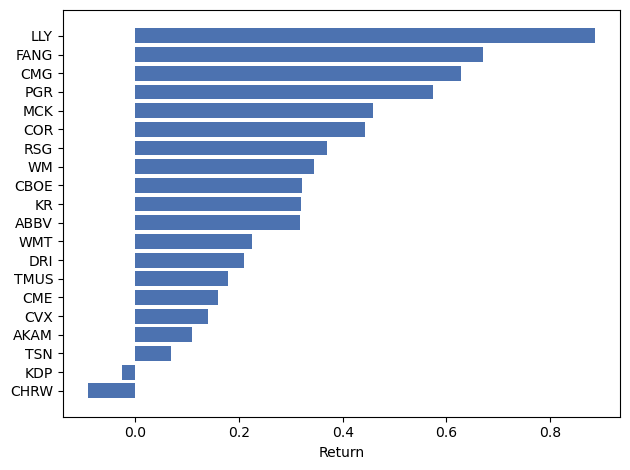

In [504]:
plotting.plot_weights(mu[weights_c.keys()], )
plotting.plt.xlabel('Return');

# semicovariance estimates

In [507]:
1.045**(1/252) -1

0.00017468543594945096

In [511]:
mu = expected_returns.ema_historical_return(df[list(syms)])
# Σ = risk_models.semicovariance(df)
S = risk_models.semicovariance(df[list(syms)], benchmark=1.045**(1/252) -1)


mu.quantile(.75)

0.36942632059346264

In [512]:
ef = EfficientFrontier(mu, S)

weights = ef.efficient_return(target_return=0.37)


weights_c = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 37.0%
Annual volatility: 9.9%
Sharpe Ratio: 3.30


In [513]:
ef.set_weights(weights_c)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 35.8%
Annual volatility: 9.4%
Sharpe Ratio: 3.34


In [514]:
weights_c={k:v for k,v in weights_c.items() if v>0}

In [515]:
wnames = {k+': '+name(k):v for k,v in weights_c.items()}

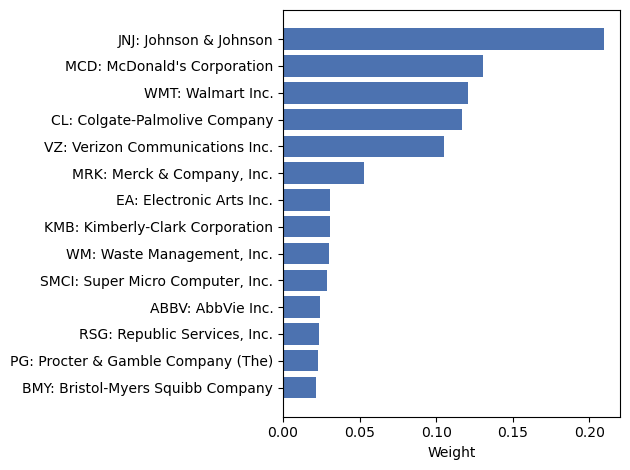

In [516]:
plotting.plot_weights(wnames,);

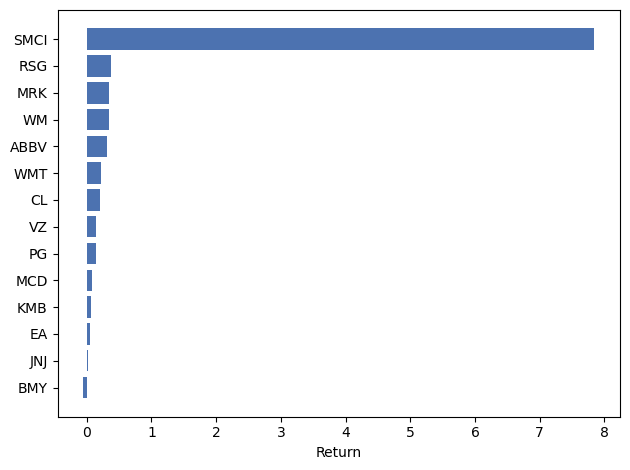

In [517]:
plotting.plot_weights(mu[weights_c.keys()], )
plotting.plt.xlabel('Return');

# Shrinkage covariance

In [531]:
mu = expected_returns.ema_historical_return(df[list(syms)])
# Σ = risk_models.semicovariance(df)
S = risk_models.risk_matrix(df[list(syms)], method='ledoit_wolf')


mu.quantile(.75)

0.36942632059346264

In [530]:
risk_models.CovarianceShrinkage??

Init signature:
risk_models.CovarianceShrinkage(
    prices,
    returns_data=False,
    frequency=252,
    log_returns=False,
)
Source:        
class CovarianceShrinkage:
    """
    Provide methods for computing shrinkage estimates of the covariance matrix, using the
    sample covariance matrix and choosing the structured estimator to be an identity matrix
    multiplied by the average sample variance. The shrinkage constant can be input manually,
    though there exist methods (notably Ledoit Wolf) to estimate the optimal value.

    Instance variables:

    - ``X`` - pd.DataFrame (returns)
    - ``S`` - np.ndarray (sample covariance matrix)
    - ``delta`` - float (shrinkage constant)
    - ``frequency`` - int
    """

    def __init__(self, prices, returns_data=False, frequency=252, log_returns=False):
        """
        :param prices: adjusted closing prices of the asset, each row is a date and each column is a ticker/id.
        :type prices: pd.DataFrame
        :param return

In [532]:
ef = EfficientFrontier(mu, S)

weights = ef.efficient_return(target_return=0.37)


weights_c = ef.clean_weights(cutoff=.02)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 37.0%
Annual volatility: 11.5%
Sharpe Ratio: 2.83


In [533]:
ef.set_weights(weights_c)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 32.5%
Annual volatility: 9.9%
Sharpe Ratio: 2.84


In [534]:
weights_c={k:v for k,v in weights_c.items() if v>0}

In [535]:
wnames = {k+': '+name(k):v for k,v in weights_c.items()}

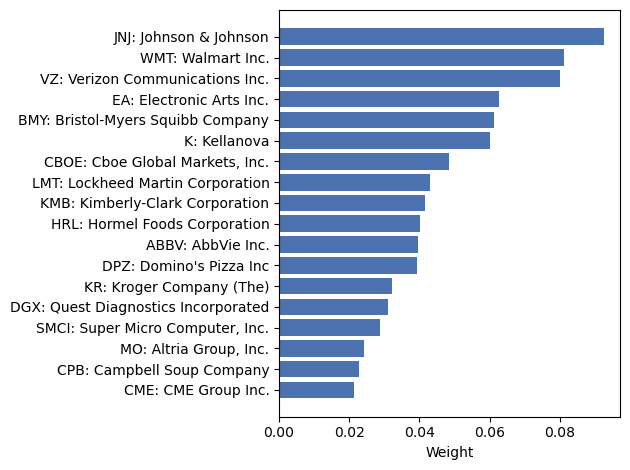

In [536]:
plotting.plot_weights(wnames,);

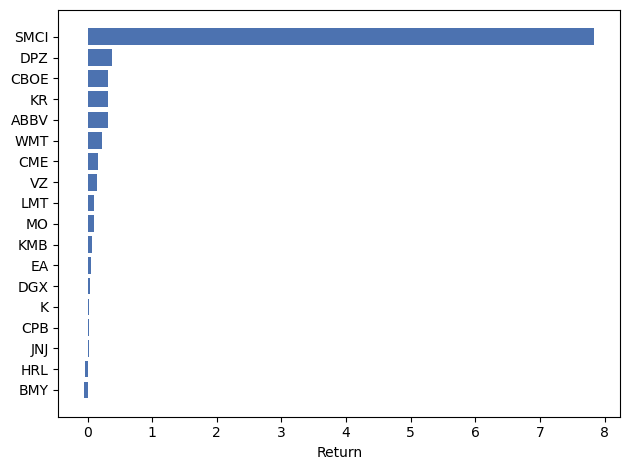

In [537]:
plotting.plot_weights(mu[weights_c.keys()], )
plotting.plt.xlabel('Return');

# bayesian methods

In [498]:
mu = expected_returns.ema_historical_return(df[list(syms)])
# Σ = risk_models.semicovariance(df)
S = risk_models.risk_matrix(df[list(syms)], method='exp_cov')


mu.quantile(.75)

0.36942632059346264

In [592]:
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

viewdict = {"AAPL": 0.20, "KLAC": 0.30, "BAC": 0, "SBUX": -0.2, "T": 0.15}
bl = BlackLittermanModel(S, absolute_views=viewdict, )



# # OR use return-implied weights
delta = black_litterman.market_implied_risk_aversion(yf.Ticker('SPY').history(period='4y')['Close'])
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
rets = bl.bl_returns()
ef = EfficientFrontier(rets, S)

bl.bl_weights(delta)
weights = bl.clean_weights()


/Users/anatoly/miniforge3/envs/port/lib/python3.11/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


In [600]:
delta

5.536857746391264

In [570]:
from tqdm.auto import tqdm


/Users/anatoly/miniforge3/envs/port/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [571]:
mcaps={s:yf.Ticker(s).info['marketCap'] for s in tqdm(sp500cl)}

100%|███████████████████████████████████████████████████████████████| 496/496 [01:28<00:00,  5.59it/s]


In [593]:

bl.portfolio_performance(verbose=True, risk_free_rate=0.045);

Expected annual return: 34.7%
Annual volatility: 55.0%
Sharpe Ratio: 0.55


In [594]:
ef.set_weights(weights)
ef.portfolio_performance(verbose=True,risk_free_rate=0.045);

Expected annual return: 34.7%
Annual volatility: 54.2%
Sharpe Ratio: 0.56


In [595]:
weights={k:v for k,v in weights.items() if v>0}

In [596]:
wnames = {k+': '+name(k):v for k,v in weights.items()}

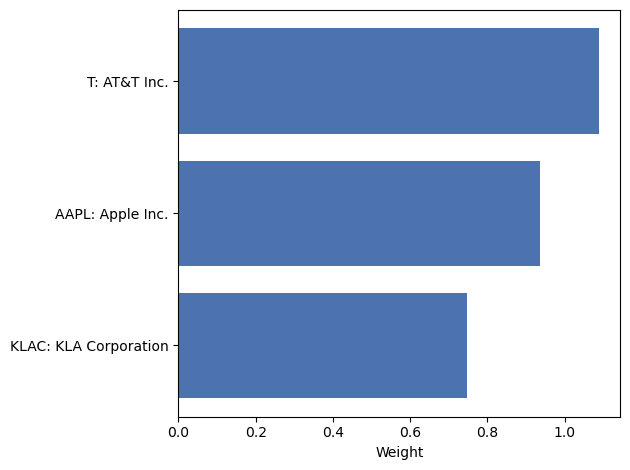

In [597]:
plotting.plot_weights(wnames,);

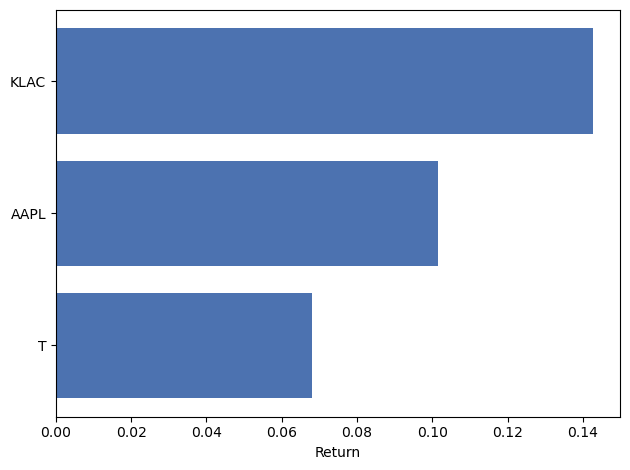

In [599]:
plotting.plot_weights(rets[weights.keys()], )
plotting.plt.xlabel('Return');

# clustering method

In [601]:
from pypfopt import hierarchical_portfolio
# from pypfopt import expected_returns

In [603]:
rets = expected_returns.returns_from_prices(df[list(syms)])
rets.sample(5)

Ticker,DECK,VTRS,SNA,SLB,IBM,AMT,AVGO,RF,ALGN,HUM,...,ZBRA,APD,CNP,ELV,V,K,IR,RCL,ROL,UNP
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,0.038729,0.011296,-0.000341,0.019598,-0.002915,0.020026,0.007446,0.039293,0.039082,0.012983,...,-0.016516,0.010851,-0.015524,0.007640,0.004041,-0.003599,0.011972,-0.006598,0.006296,-0.008232
2020-10-09,0.024260,-0.005089,-0.007450,-0.012173,-0.028139,0.004598,0.009027,-0.019172,0.003266,0.014322,...,0.017593,0.003137,0.002346,0.003819,0.018031,0.009660,-0.002686,0.025978,0.007892,0.009814
2020-06-09,-0.024994,-0.017572,-0.029604,-0.048203,-0.028582,-0.004197,-0.006929,-0.027457,-0.034651,-0.019895,...,-0.024327,0.005169,-0.024096,-0.028801,-0.002605,-0.014441,-0.055381,-0.069356,-0.024007,-0.019267
2020-06-01,0.072810,0.032221,0.002467,-0.002166,-0.000080,0.023783,-0.004395,0.015031,0.020072,-0.022281,...,0.013968,0.003931,0.015185,-0.013872,-0.004559,0.012249,0.019858,0.072682,0.010048,-0.002120
2021-06-02,-0.031828,0.013106,-0.005281,0.076829,0.010611,0.016862,0.011574,-0.015665,-0.030313,-0.005449,...,0.003678,0.010313,-0.000797,-0.001902,0.013370,0.014971,-0.005996,0.007584,0.004739,-0.002577


In [656]:
hp = hierarchical_portfolio.HRPOpt(rets, )

In [657]:
hp.clusters

In [658]:
len(syms)

496

method=’single’ assigns


for all points  in cluster  and  in cluster . This is also known as the Nearest Point Algorithm.

method=’complete’ assigns


for all points  in cluster u and  in cluster . This is also known by the Farthest Point Algorithm or Voor Hees Algorithm.

method=’average’ assigns


for all points  and  where  and  are the cardinalities of clusters  and , respectively. This is also called the UPGMA algorithm.

method=’weighted’ assigns


where cluster u was formed with cluster s and t and v is a remaining cluster in the forest (also called WPGMA).

method=’centroid’ assigns


where  and  are the centroids of clusters  and , respectively. When two clusters  and are combined into a new cluster , the new centroid is computed over all the original objects in clusters  and . The distance then becomes the Euclidean distance between the centroid of and the centroid of a remaining cluster  in the forest. This is also known as the UPGMC algorithm.

method=’median’ assigns  like the centroid method. When two clusters  and  are combined into a new cluster , the average of centroids s and t give the new centroid . This is also known as the WPGMC algorithm.

method=’ward’ uses the Ward variance minimization algorithm. The new entry  is computed as follows,


where  is the newly joined cluster consisting of clusters  and ,  is an unused cluster in the forest, , and  is the cardinality of its argument. This is also known as the incremental algorithm.


In [665]:
weights = hp.optimize(linkage_method='ward')
print(f'non-zero weights: {len([s for s in weights if weights[s]>0])}')

hp.portfolio_performance(verbose=True);

non-zero weights: 496
Expected annual return: 19.2%
Annual volatility: 16.1%
Sharpe Ratio: 1.07


In [666]:
weights=hp.clean_weights(cutoff=.001)
hp.set_weights(weights)
hp.portfolio_performance(verbose=True);

Expected annual return: 16.3%
Annual volatility: 14.2%
Sharpe Ratio: 1.01


In [664]:
len([s for s in weights if weights[s]>0])

188

<AxesSubplot: >

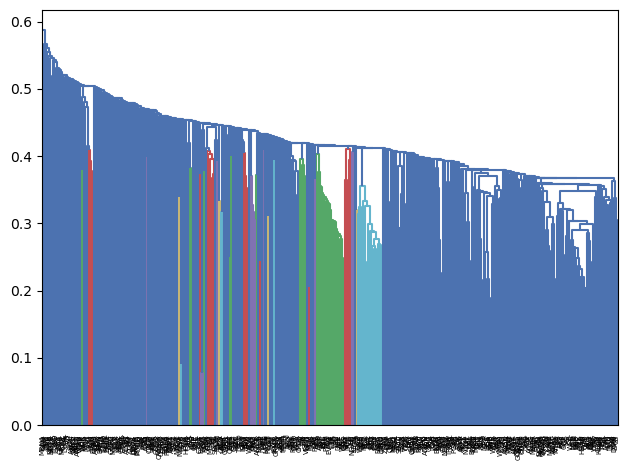

In [652]:
plotting.plot_dendrogram(hp)